In [1]:
import pandas as pd
import datetime as dt
import pymongo
import dns
import geopandas as gpd
import matplotlib.pyplot as plt
import panel as pn
import panel.widgets as pnw
import json
import pycountry
from bokeh.io import output_file, show, output_notebook, export_png
from bokeh.models import ColumnDataSource, GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
pn.extension()

username = "Freddoloso"
password = "Milano01"
url = "mongodb+srv://%s:%s@cluster0.gg85x.mongodb.net/<dbname>?retryWrites=true&w=majority"
client = pymongo.MongoClient(url % (username, password))

db = client["Guarda_che_freddo"]
col = db["mappa_temperature"]


def select_data (year=None):
    
    year=year
    d_start = dt.datetime(year, 1, 1)
    d_end = dt.datetime(year+1, 1, 1)

    df =pd.DataFrame(
        col.aggregate([
            {"$match":{"dt": {"$gte": d_start , "$lt": d_end}}},
            {"$group":
                {
                    "_id": "$Country" ,
                    "AverageTemperatureCountry" : {"$avg": "$AverageTemperature"}
                }
            },
            {"$project": {
              "_id": 0,
              "Country": "$_id",
              "AverageTemp": "$AverageTemperatureCountry",
              "count": 1,
              "sum": 1
           }}
    ]))
    
    
    return df

def search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
        return result[0].alpha_3
    except:
        return 'NaN'

def merge_shape_file (year=None ):
    
    shapefile = 'data\\world_map\\world_map.shp'
    df=select_data(year)
    
    df.head()
    df.columns
  
    #Read shapefile using Geopandas
    #print(gpd.read_file(shapefile))
    gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

    #Rename columns.
    gdf.columns = ['country', 'country_code', 'geometry']
    df["code"] = df["Country"].apply(lambda country: search(country))
    key = df.columns[1]
    data = gdf.merge(df, left_on = 'country_code', right_on = 'code', how = 'left')
    data[key] = data[key].fillna(0)     
    
    return data, key


Text(0.5, 1.0, '2013 Temperature medie')

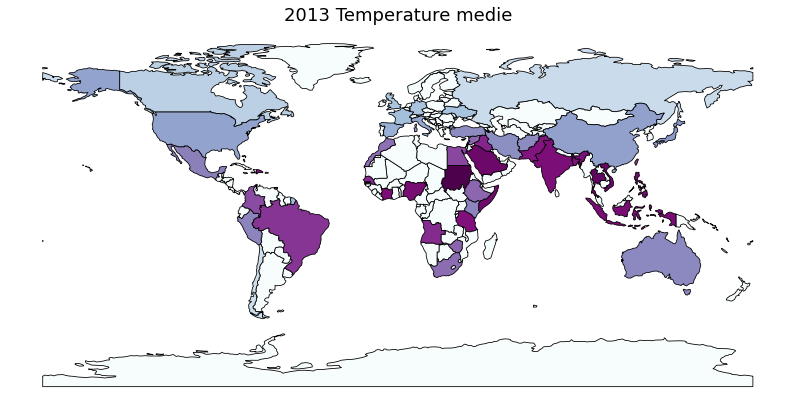

In [3]:
year=2013
data,key=merge_shape_file(year)    
fig, ax = plt.subplots(1, figsize=(14, 8));
data.plot(column=key, cmap='BuPu', linewidth=0.8, ax=ax, edgecolor='black')
ax.axis('off')
ax.set_title('%s Temperature medie' %year, fontsize=18)


In [4]:
data.head()

,country,country_code,geometry,Country,AverageTemp,code
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,0.000000,NaN
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,26.763125,TZA
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,0.000000,NaN
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",Canada,8.159889,CAN
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States,13.957148,USA


In [5]:
def get_geodatasource(gdf):    
    """Get getjsondatasource from geopandas object"""
    json_data = json.dumps(json.loads(gdf.to_json()))
    return GeoJSONDataSource(geojson = json_data)

def bokeh_plot_map(gdf, column=None, title=''):
    """Plot bokeh map from GeoJSONDataSource """

    geosource = get_geodatasource(gdf)
    palette = brewer['BuPu'][8]
    palette = palette[::-1]
    vals = gdf[column]
    #Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = vals.min(), high = vals.max())
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8, width=500, height=20,
                         location=(0,0), orientation='horizontal')

    tools = 'wheel_zoom,pan,reset'
    p = figure(title = title, plot_height=400 , plot_width=850, toolbar_location='right', tools=tools)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    #Add patch renderer to figure
    p.patches('xs','ys', source=geosource, fill_alpha=1, line_width=0.5, line_color='black',  
              fill_color={'field' :column , 'transform': color_mapper})
    #Specify figure layout.
    p.add_layout(color_bar, 'below')
    return p

def map_dash():
    
    from bokeh.models.widgets import DataTable
    map_pane = pn.pane.Bokeh(width=800)
    year_slider = pnw.IntSlider(start=1743,end=2013,value=2013)
    def update_map(event):
        gdf,key = merge_shape_file (year=year_slider.value)        
        map_pane.object = bokeh_plot_map(gdf, key )        
        return
    year_slider.param.watch(update_map,'value')
    year_slider.param.trigger('value')
    app = pn.Column(year_slider,map_pane)
    return app



In [6]:
app = map_dash()
app

Column
    [0] IntSlider(end=2013, start=1743, value=2013, value_throttled=2013)
    [1] Bokeh(Figure, width=800)